In [1]:
import torch
from torch.utils.data import DataLoader
from config import antibiotics,ab_order
from sklearn.metrics import confusion_matrix
from model import ScaleAdaptiveNet
from data import SpectralDataset,train_transform,valid_transform
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from utils import Engine,EarlyStop,seed_everything
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import warnings

In [2]:
warnings.filterwarnings("ignore")
device = 'cuda:0'
dataset = '2018clinical'
batch_size=10

### load the clinical dataset

In [3]:
X = np.load('/home/scu-its-gpu-002/Documents/DataSet/bacteria-ID/X_' + dataset + '.npy')
y = np.load('/home/scu-its-gpu-002/Documents/DataSet/bacteria-ID/y_' + dataset + '.npy')
num = y.shape[0]//25

### directly test the pretrained model on the clinical set

In [4]:
net = ScaleAdaptiveNet(num_classes=8).to(device)
net.load_state_dict(torch.load('param/8/pretrain/1.pth'))

<All keys matched successfully>

In [5]:
clinical_set = SpectralDataset(X,y,None,valid_transform,False,False)
clinical_loader = DataLoader(clinical_set, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
lossF = nn.CrossEntropyLoss().to(device)

In [6]:
_, pred, true, _, _ = Engine.test(clinical_loader, lossF, net, device)

Average test loss is 0.715079, the accuracy rate of testset is 0.7867 : 100%|██████████| 1000/1000 [00:07<00:00, 133.42it/s]


### random sampled 5 spectra from each patient and take the mode as the predtiction. (repeat for 10000 trials)

In [7]:
trials = 10000
n_spectra = 5

In [8]:
preds = np.zeros((25, trials))
labels = np.zeros((25, trials))
for i in range(25):
    labels[i] = true[num * i]
    for k in range(trials):
        y_patient = pred[num * i:num * i + num]
        idxs = np.random.permutation(np.arange(len(y_patient)))[:n_spectra]
        preds[i, k] = stats.mode(np.array(y_patient)[idxs])[0][0]

### plot the confusion matrix

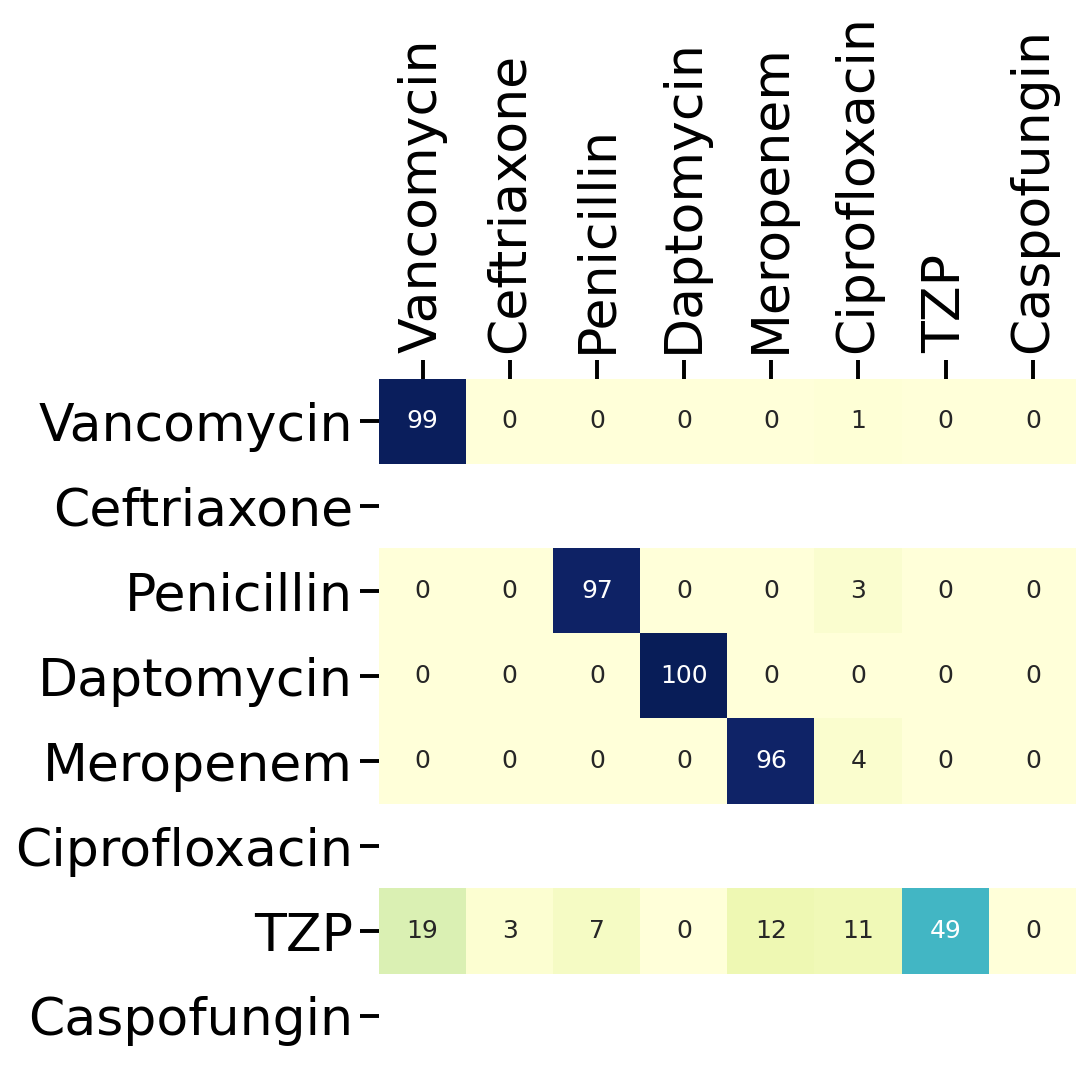

In [9]:
sns.set_context("talk", rc={"font": "Helvetica", "font.size": 12})
label = [antibiotics[i] for i in ab_order]
fig = plt.figure(figsize=(6,6),dpi=150)
cm = confusion_matrix(labels.flatten(), preds.flatten(), labels=ab_order)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f', xticklabels=label, yticklabels=label,cbar=False)
ax.xaxis.tick_top()
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [10]:
acc = (preds == labels).mean(0)
avg = acc.mean()
std = acc.std()
print('Average Accuracy:{:2f}%,Standard deviation:{:2f}%'.format(100*avg,100*std))

Average Accuracy:88.148000%,Standard deviation:4.337799%


### The 5 patients of each class are assigned to [train,train,train,val,test]
randomly sample 5 spectra from train patients

In [11]:
seed_everything(42)
patient_id = []
for i in range(5):
    x = list(range(5))
    np.random.shuffle(x)
    patient_id.append(x)
train,val,test=[],[],[]
for group_id,patient_list in enumerate(patient_id):
    print('Group {} patients'.format(group_id))
    print(' Tr: {}'.format(patient_list[:3]))
    print(' Val: {}'.format(patient_list[3]))
    print(' Te : {}'.format(patient_list[4]))
    for j,patient in enumerate(patient_list):
        start_id = 5*num*group_id+num*patient
        id_range = list(range(start_id,start_id+num))
        if j<3:
            np.random.shuffle(id_range)
            id_sample = id_range[:n_spectra]
            train.extend(id_sample)
        elif j==3:
            val+=id_range
        else:
            test+=id_range

Group 0 patients
 Tr: [1, 4, 2]
 Val: 0
 Te : 3
Group 1 patients
 Tr: [3, 1, 2]
 Val: 0
 Te : 4
Group 2 patients
 Tr: [1, 0, 3]
 Val: 4
 Te : 2
Group 3 patients
 Tr: [0, 1, 2]
 Val: 3
 Te : 4
Group 4 patients
 Tr: [0, 2, 3]
 Val: 1
 Te : 4


In [12]:
def clinicalloader(X_,y_):
    trainset = SpectralDataset(X_, y_, train, train_transform, antibiotics=False, mssa_mrsa=False)
    valset = SpectralDataset(X_,y_,val,valid_transform,antibiotics=False,mssa_mrsa=False)
    testset = SpectralDataset(X_, y_, test, valid_transform, antibiotics=False, mssa_mrsa=False)
    trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=12, shuffle=True,pin_memory=True)
    valloader = DataLoader(valset, batch_size=batch_size, num_workers=12, shuffle=False, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
    return trainloader,valloader,testloader

In [13]:
optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=1e-4,weight_decay=1e-6)
sheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
trainloader,valloader,testloader = clinicalloader(X,y)
es = EarlyStop(10)

### Train for 20 epochs

In [14]:
for epoch in range(1, 21):
    train_acc, train_loss = Engine.train(1, epoch, trainloader, lossF, net, optimizer, device, sheduler, 1,
                                             fp16=False, sheduler_type='CosineAnnealingLR')
    val_acc, val_loss = Engine.evaluate(1, epoch, valloader, lossF, net, device)
    es(val_acc, net, 'param/8/finetune/' +dataset+ '.pth')
    if es.early_stop:
        break

Fold1, Epoch1 : Average train loss is 0.797242, the accuracy rate of trainset is 0.7733 : 100%|██████████| 8/8 [00:00<00:00, 15.34it/s]
Fold1, Epoch1,: Average validate loss is 0.506562, the accuracy rate of valset is 0.8345 : 100%|██████████| 200/200 [00:01<00:00, 115.64it/s]
Fold1, Epoch2 : Average train loss is 0.566220, the accuracy rate of trainset is 0.8267 : 100%|██████████| 8/8 [00:00<00:00, 16.63it/s]
Fold1, Epoch2,: Average validate loss is 0.298252, the accuracy rate of valset is 0.8910 : 100%|██████████| 200/200 [00:01<00:00, 117.93it/s]
Fold1, Epoch3 : Average train loss is 0.361548, the accuracy rate of trainset is 0.8800 : 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]
Fold1, Epoch3,: Average validate loss is 0.185919, the accuracy rate of valset is 0.9365 : 100%|██████████| 200/200 [00:01<00:00, 116.99it/s]
Fold1, Epoch4 : Average train loss is 0.231314, the accuracy rate of trainset is 0.9067 : 100%|██████████| 8/8 [00:00<00:00, 16.62it/s]
Fold1, Epoch4,: Average valida

### Test on test split

In [15]:

net.load_state_dict(torch.load('param/8/finetune/' +dataset+ '.pth'))
_, pred, true, _, _ = Engine.test(testloader, lossF, net, device)

Average test loss is 0.219074, the accuracy rate of testset is 0.9170 : 100%|██████████| 200/200 [00:01<00:00, 122.54it/s]


In [16]:
preds = np.zeros((5, trials))
labels = np.zeros((5, trials))
for i in range(5):
    labels[i] = true[num * i]
    for k in range(trials):
        y_patient = pred[num * i:num * i + num]
        idxs = np.random.permutation(np.arange(len(y_patient)))[:n_spectra]
        preds[i, k] = stats.mode(np.array(y_patient)[idxs])[0][0]

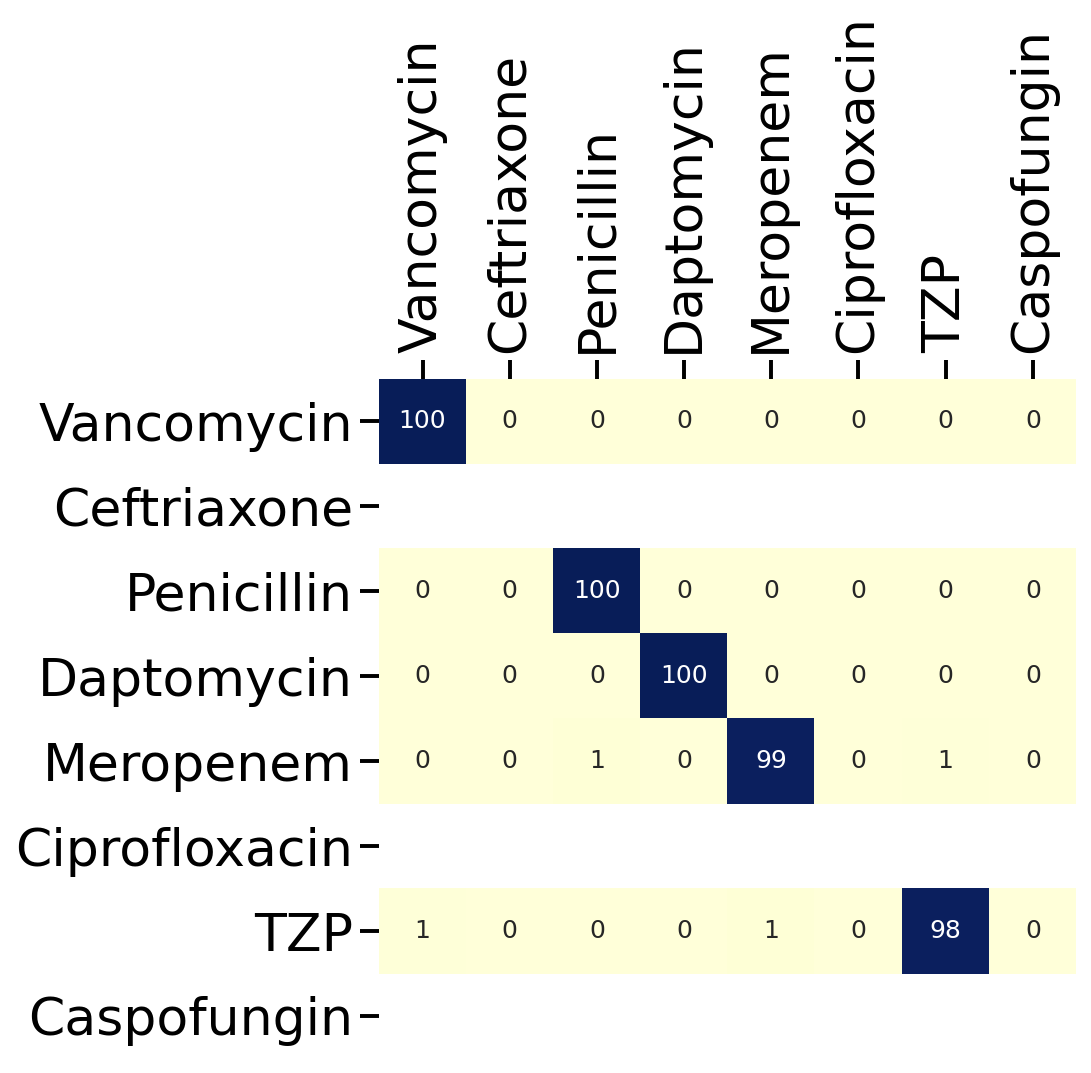

In [17]:
sns.set_context("talk", rc={"font": "Helvetica", "font.size": 12})
label = [antibiotics[i] for i in ab_order]
fig = plt.figure(figsize=(6,6),dpi=150)
cm = confusion_matrix(labels.flatten(), preds.flatten(), labels=ab_order)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f', xticklabels=label, yticklabels=label,cbar=False)
ax.xaxis.tick_top()
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [18]:
acc = (preds == labels).mean(0)
avg = acc.mean()
std = acc.std()
print('Average Accuracy:{:2f}%,Standard deviation:{:2f}%'.format(100*avg,100*std))

Average Accuracy:99.396000%,Standard deviation:3.446039%


## Continue Finetune on 2019 clinical data

In [19]:
dataset = '2019clinical'
X1 = np.load('/home/scu-its-gpu-002/Documents/DataSet/bacteria-ID/X_' + dataset + '.npy')
y1 = np.load('/home/scu-its-gpu-002/Documents/DataSet/bacteria-ID/y_' + dataset + '.npy')
num = y1.shape[0]//25

In [20]:
patient_id = []
for i in range(5):
    x = list(range(5))
    np.random.shuffle(x)
    patient_id.append(x)
train,val,test=[],[],[]
for group_id,patient_list in enumerate(patient_id):
    print('Group {} patients'.format(group_id))
    print(' Tr: {}'.format(patient_list[:3]))
    print(' Val: {}'.format(patient_list[3]))
    print(' Te : {}'.format(patient_list[4]))
    for j,patient in enumerate(patient_list):
        start_id = 5*num*group_id+num*patient
        id_range = list(range(start_id,start_id+num))
        if j<3:
            np.random.shuffle(id_range)
            id_sample = id_range[:n_spectra]
            train.extend(id_sample)
        elif j==3:
            val+=id_range
        else:
            test+=id_range

Group 0 patients
 Tr: [4, 2, 1]
 Val: 3
 Te : 0
Group 1 patients
 Tr: [4, 3, 1]
 Val: 0
 Te : 2
Group 2 patients
 Tr: [4, 0, 2]
 Val: 1
 Te : 3
Group 3 patients
 Tr: [4, 3, 2]
 Val: 1
 Te : 0
Group 4 patients
 Tr: [2, 1, 0]
 Val: 3
 Te : 4


In [21]:
optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=1e-4,weight_decay=1e-6)
sheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
trainloader,valloader,testloader = clinicalloader(X1,y1)
es = EarlyStop(10)

In [22]:
for epoch in range(1, 21):
    train_acc, train_loss = Engine.train(1, epoch, trainloader, lossF, net, optimizer, device, sheduler, 1,
                                             fp16=False, sheduler_type='CosineAnnealingLR')
    val_acc, val_loss = Engine.evaluate(1, epoch, valloader, lossF, net, device)
    es(val_acc, net, 'param/8/finetune/' +dataset+ '.pth')
    if es.early_stop:
        break

Fold1, Epoch1 : Average train loss is 0.916097, the accuracy rate of trainset is 0.8267 : 100%|██████████| 8/8 [00:00<00:00, 16.45it/s]
Fold1, Epoch1,: Average validate loss is 0.285170, the accuracy rate of valset is 0.8780 : 100%|██████████| 50/50 [00:00<00:00, 86.18it/s]
Fold1, Epoch2 : Average train loss is 0.531639, the accuracy rate of trainset is 0.8667 : 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
Fold1, Epoch2,: Average validate loss is 0.295529, the accuracy rate of valset is 0.8740 : 100%|██████████| 50/50 [00:00<00:00, 77.59it/s]
Fold1, Epoch3 : Average train loss is 0.297800, the accuracy rate of trainset is 0.8933 : 100%|██████████| 8/8 [00:00<00:00, 14.68it/s]
Fold1, Epoch3,: Average validate loss is 0.385242, the accuracy rate of valset is 0.8520 : 100%|██████████| 50/50 [00:00<00:00, 88.86it/s]
Fold1, Epoch4 : Average train loss is 0.419878, the accuracy rate of trainset is 0.9067 : 100%|██████████| 8/8 [00:00<00:00, 15.95it/s]
Fold1, Epoch4,: Average validate loss i

In [23]:
net.load_state_dict(torch.load('param/8/finetune/' +dataset+ '.pth'))
_, pred, true, _, _ = Engine.test(testloader, lossF, net, device)

Average test loss is 0.245170, the accuracy rate of testset is 0.9260 : 100%|██████████| 50/50 [00:00<00:00, 83.23it/s]


In [24]:
preds = np.zeros((5, trials))
labels = np.zeros((5, trials))
for i in range(5):
    labels[i] = true[num * i]
    for k in range(trials):
        y_patient = pred[num * i:num * i + num]
        idxs = np.random.permutation(np.arange(len(y_patient)))[:n_spectra]
        preds[i, k] = stats.mode(np.array(y_patient)[idxs])[0][0]

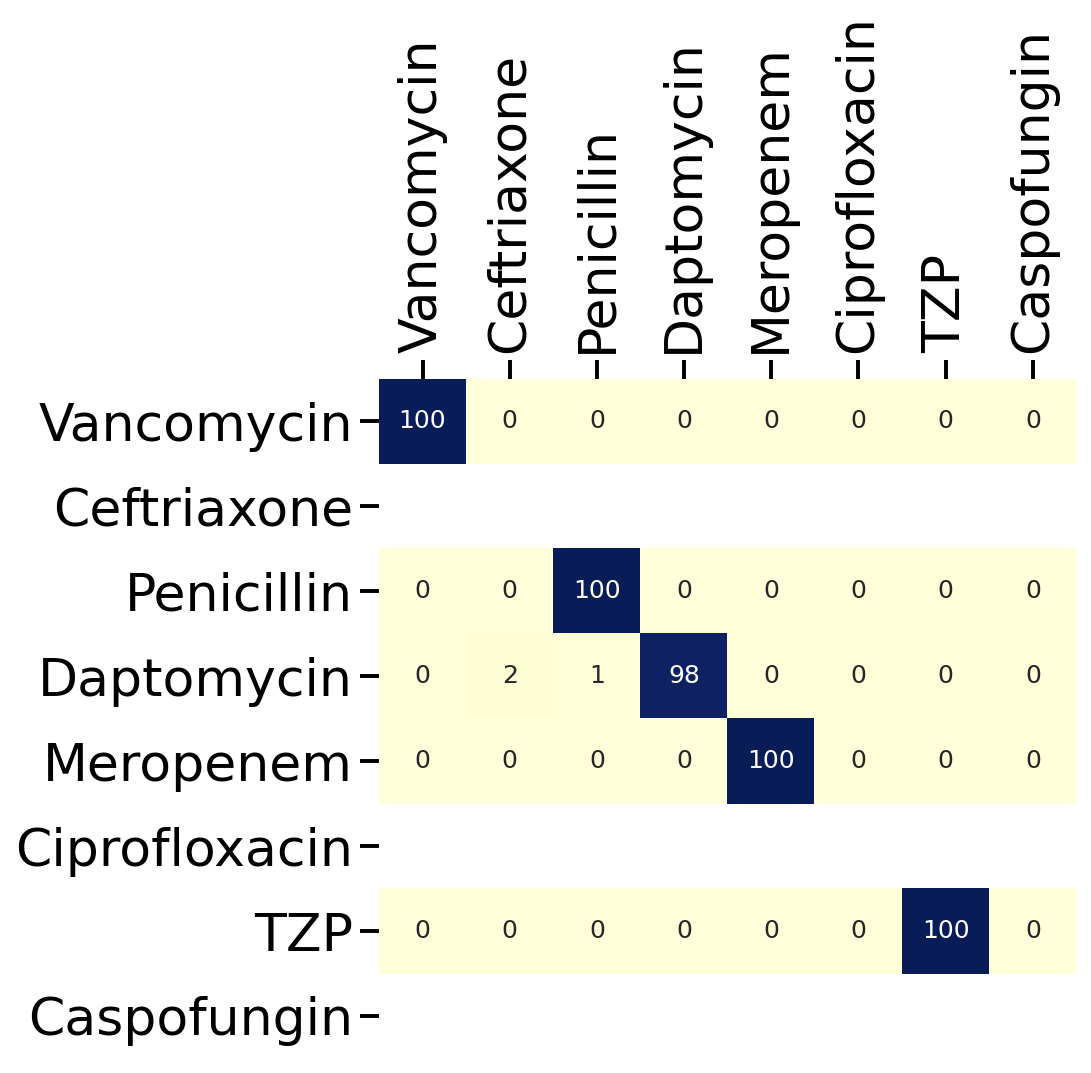

In [25]:
sns.set_context("talk", rc={"font": "Helvetica", "font.size": 12})
label = [antibiotics[i] for i in ab_order]
fig = plt.figure(figsize=(6,6),dpi=150)
cm = confusion_matrix(labels.flatten(), preds.flatten(), labels=ab_order)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f', xticklabels=label, yticklabels=label,cbar=False)
ax.xaxis.tick_top()
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [26]:
acc = (preds == labels).mean(0)
avg = acc.mean()
std = acc.std()
print('Average Accuracy:{:2f}%,Standard deviation:{:2f}%'.format(100*avg,100*std))

Average Accuracy:99.386000%,Standard deviation:3.461648%
